In [2]:
import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum

In [3]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'fold1'

In [4]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models'][model_name]

In [5]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [6]:
features = MelSpectrogram(**params_features)
features.check_if_extracted(dataset)

True

In [7]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    }
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

(50, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 32)       1075200     features[0][0]                   
__________________________________________________________________________________________________
s

In [8]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_val,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [9]:
X, Y = data_gen.get_data()
print(X.shape, Y.shape)

(888, 84, 128) (888, 10)


[0 4 2 9 3]
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


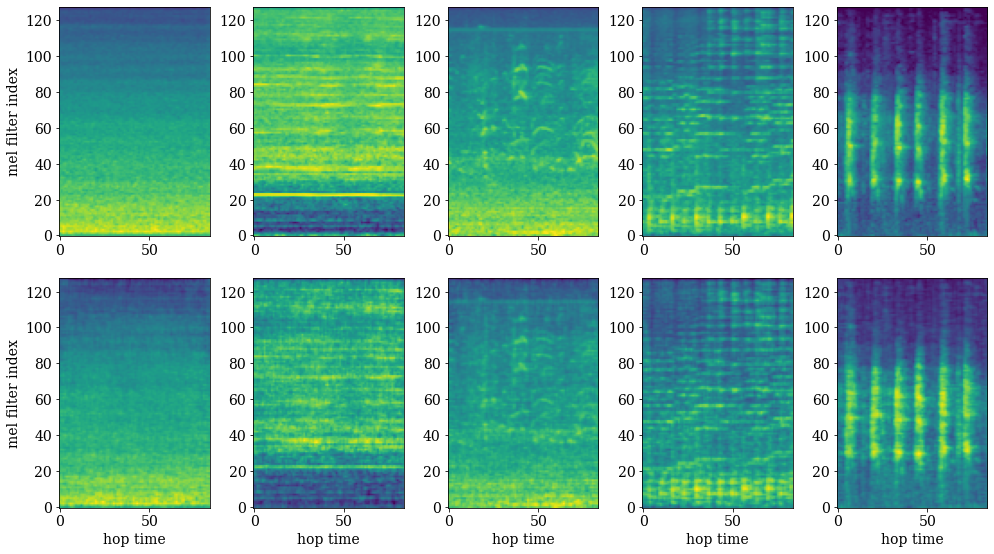

In [10]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})


plt.figure(figsize=(14,8))
n_classes = len(dataset.label_list)

ixs = [0, 50, 190, 650, 1]
#print(np.argwhere(np.argmax(Y, axis=1)==3))
class_ix = np.argmax(Y[ixs], axis=1)
print(class_ix)
print(dataset.label_list)
reconstructions = model_container.model.predict(X[ixs])[1]

mel_bands = int(X.shape[-1])
hop_times = int(X.shape[-2])
yticks = [0,mel_bands//4-1, mel_bands//2-1, 3*mel_bands//4-1, mel_bands-1]
xticks = [0,hop_times//2-1, hop_times-1]

for j in range(5):
    plt.subplot(2,5,j+1)
    plt.imshow(X[ixs[j]].T,origin='lower')
    if j == 0:
        plt.ylabel('mel filter index')

    plt.subplot(2,5,j+6)
    plt.imshow(reconstructions[j].T,origin='lower')
    plt.xlabel('hop time')
    if j == 0:
        plt.ylabel('mel filter index')

plt.tight_layout()
plt.savefig('images/autoencoder.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()    